In [25]:
#this notebook does not account for actions taken between the last step in an episode and first step in subsequent episode
#see physicion_intermediate_acps.ipynb for alternate acp and air calculation for the entire time series
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from cost_func import compute_acp_cost, overall_acp_cost, compute_map_physician_air, compute_hr_physician_air, compute_pulsatility_physician_air, aggregate_air_physician, is_stable, weaning_score_physician
from reward_func import compute_reward_smooth


DATA_PATH = "/abiomed/downsampled/10min_1hr_window.pkl"
N_REWARD_EPISODES = 100
#this is just for the visualization so it isn't messy
MAX_STEPS_TO_PLOT = 2000

In [2]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
#this is a check to see what is included in the pkl file and hoow many episodes
print(f"there are {list(data.keys())} keys in dataset")
episodes = data['train']
print(f"episodes: {len(episodes)}")
print(f"shape is {data['train'].shape}")


there are ['train', 'val', 'test', 'mean', 'std'] keys in dataset
episodes: 4309
shape is torch.Size([4309, 12, 13])


In [3]:
#to numpy if tensor
if isinstance(episodes, torch.Tensor):    
    episodes_np = episodes.numpy()  
else:
    episodes_np = np.array(episodes)

In [4]:
all_steps_np = np.concatenate(episodes_np, axis=0)
total_steps_available = all_steps_np.shape[0]
print(f"Total timesteps: {total_steps_available}")

# Group the data in bins with 24 steps
episode_length = 24
num_bins = total_steps_available // episode_length
#creates bins and fits the samples into 3D
binned_steps = all_steps_np[:num_bins * episode_length].reshape(num_bins, episode_length, -1)
print(f"Created {num_bins} bins with {episode_length} steps")
# Randomly select 100 of these bins
num_episodes_to_sample = 633
#no replacement
sampled_bin_indices = np.random.choice(num_bins, num_episodes_to_sample, replace=False)

all_episode_rewards = []

# Loop through the 100 randomly selected bins
for bin_idx in sampled_bin_indices:
    # Get one bin
    episode_bin = binned_steps[bin_idx]
    
    normalized_rewards_for_episode = []
    # Loop through each of the 24 steps in the bin
    for step_data in episode_bin:
        step_tensor = torch.tensor(step_data, dtype=torch.float32)
        raw_reward = compute_reward_smooth(step_tensor.unsqueeze(0))
        
        # Apply normalization from rl_env
        norm_reward = (raw_reward + 4) / 5
        clipped_reward = np.clip(norm_reward, -1.0, 1.0)
        normalized_rewards_for_episode.append(clipped_reward)
    
    # Find the total reward for this simulated episode
    total_episode_reward = sum(normalized_rewards_for_episode)
    all_episode_rewards.append(total_episode_reward)

mean_total_episode_reward = np.mean(all_episode_rewards)

print(f"Mean total normalized reward per episode from all bins: {mean_total_episode_reward:.6f}")


Total timesteps: 51708
Created 2154 bins with 24 steps
Mean total normalized reward per episode from all bins: -12.799036


In [5]:
states_all = episodes_np[:, :, :-1]
actions_all = episodes_np[:, :, -1]
episode_lengths = [len(ep) for ep in actions_all]
episode_boundaries = np.cumsum(episode_lengths)


print(f"Shape of dataset: {episodes_np.shape}")

episode_idx_to_check = 0
num_states_in_episode = len(states_all[episode_idx_to_check])
num_actions_in_episode = len(actions_all[episode_idx_to_check])
print(f"States in episode: {num_states_in_episode} and actions in episode: {num_actions_in_episode}")

print(f"First 5 episodes in hours: {episode_lengths[:5]}")
print(f"Min episode length: {np.min(episode_lengths)} hours")
print(f"Max episode length: {np.max(episode_lengths)} hours")


Shape of dataset: (4309, 12, 13)
States in episode: 12 and actions in episode: 12
First 5 episodes in hours: [12, 12, 12, 12, 12]
Min episode length: 12 hours
Max episode length: 12 hours


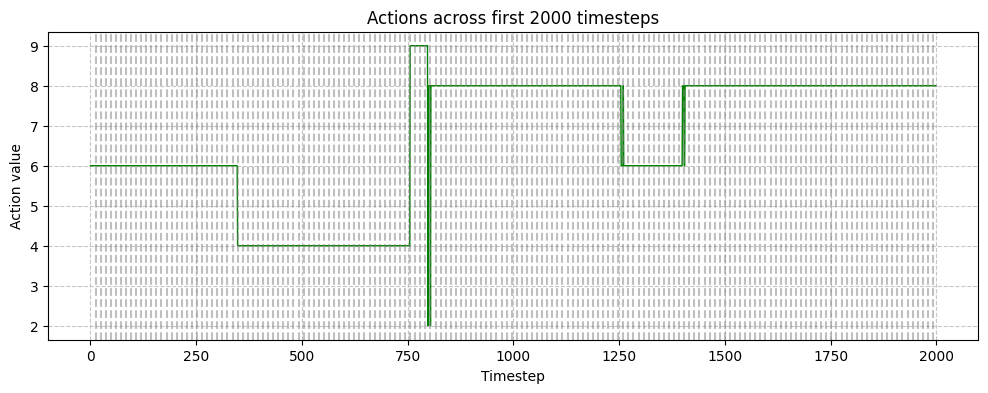

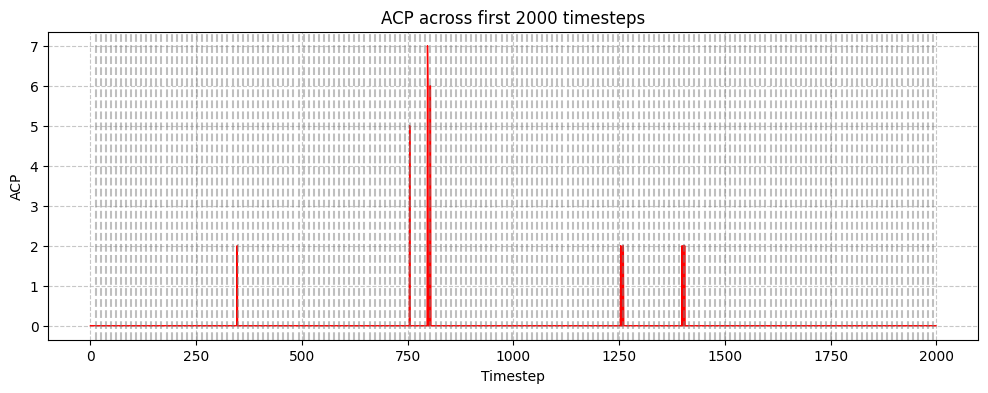

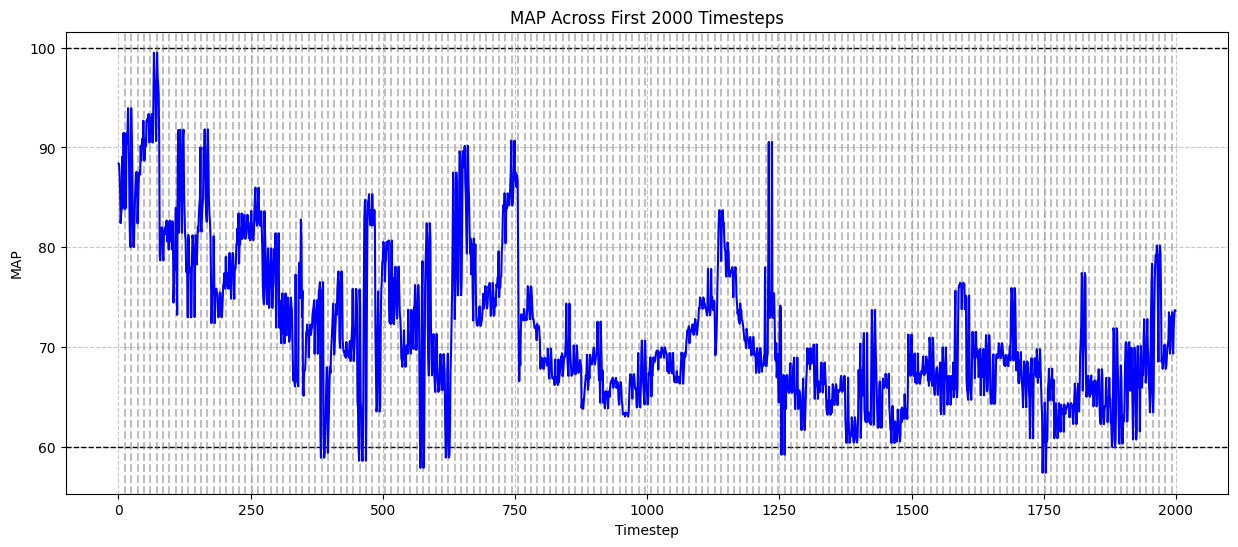

In [6]:
#this is to fill in the missing acp between episodes (wasn't sure if this should be part of mean)
flattened_actions = actions_all.flatten()
flattened_acp = []
prev_action = None
for ep_actions in actions_all:
    for action in ep_actions:
        if prev_action is not None:
            flattened_acp.append(np.linalg.norm(action - prev_action))
        prev_action = action
flattened_acp = np.array(flattened_acp)

#recalculate acp including the change between episodes

flattened_actions = flattened_actions[:MAX_STEPS_TO_PLOT]
flattened_acp = flattened_acp[:MAX_STEPS_TO_PLOT]
episode_boundaries = episode_boundaries[episode_boundaries < MAX_STEPS_TO_PLOT]
flattened_map = all_steps_np[:, 0]
flattened_map = flattened_map[:MAX_STEPS_TO_PLOT]

#action graph over timesteps
#I was getting confused where to check for episode ends so there are vertical lines for those
plt.figure(figsize=(12, 4))
plt.plot(flattened_actions, color='green', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Action value")
plt.title("Actions across first 2000 timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#acp graph over timesteps
plt.figure(figsize=(12, 4))
plt.plot(flattened_acp, color='red', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("ACP")
plt.title("ACP across first 2000 timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#map with unsafe regions highlighted
plt.figure(figsize=(15, 6))
timesteps = np.arange(len(flattened_map))
plt.plot(timesteps, flattened_map, color='blue', linewidth=1.5, label='MAP', zorder=5)
plt.fill_between(timesteps, 60, flattened_map, where=flattened_map < 60, 
                 color='red', alpha=0.3, interpolate=True, label='MAP < 60')
plt.fill_between(timesteps, 100, flattened_map, where=flattened_map > 100, 
                 color='red', alpha=0.3, interpolate=True, label='MAP > 100')
plt.axhline(y=60, color='black', linestyle='--', linewidth=1)
plt.axhline(y=100, color='black', linestyle='--', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("MAP")
plt.title("MAP Across First 2000 Timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

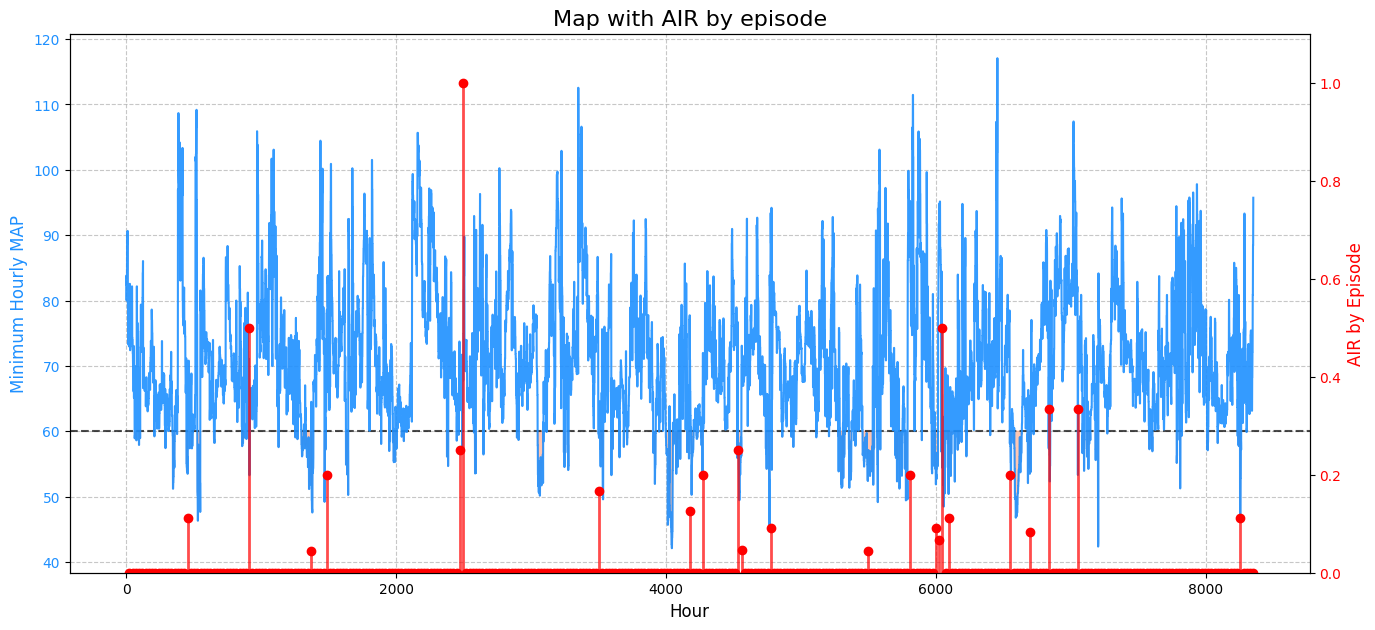

In [7]:
actions_np = np.array(actions_all)
states_np = np.array(states_all)
num_episodes = len(actions_np) // 144
new_size = num_episodes * 144
trimmed_actions = actions_np[:new_size]
trimmed_states = states_np[:new_size]

long_episode_actions = trimmed_actions.reshape(-1, 144)
num_features = states_np.shape[-1]
long_episode_states = trimmed_states.reshape(-1, 144, num_features)

all_episode_rates = []
for i in range(len(long_episode_actions)):
    episode_actions = long_episode_actions[i]
    episode_map = long_episode_states[i, :, 0]
    rate = compute_map_physician_air(episode_map, episode_actions)
    all_episode_rates.append(rate)

episode_boundaries = np.arange(1, len(long_episode_actions) + 1) * 144
full_flattened_map = long_episode_states[:, :, 0].flatten()

HOURLY_WINDOW = 6
num_windows = len(full_flattened_map) // HOURLY_WINDOW
trimmed_map_for_hourly_min = full_flattened_map[:num_windows * HOURLY_WINDOW]

hourly_min_map = trimmed_map_for_hourly_min.reshape(-1, HOURLY_WINDOW).min(axis=1)
hourly_timesteps = np.arange(num_windows)
fig, ax1 = plt.subplots(figsize=(16, 7))
plt.title('Map with AIR by episode', fontsize=16)

color = 'dodgerblue'
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_ylabel('Minimum Hourly MAP', color=color, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.plot(hourly_timesteps, hourly_min_map, color=color, label='Min MAP Per Hour', alpha=0.9, zorder=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=60, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.fill_between(hourly_timesteps, 60, hourly_min_map, where=hourly_min_map < 60, 
                 color='orangered', alpha=0.3, interpolate=True, label='Min MAP < 60') 


ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('AIR by Episode', color=color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.1)


valid_rates = []
valid_boundaries_scaled = []
for i, rate in enumerate(all_episode_rates):
    valid_rates.append(rate)
    valid_boundaries_scaled.append(episode_boundaries[i] / HOURLY_WINDOW)


markerline, stemlines, baseline = ax2.stem(
    valid_boundaries_scaled,
    valid_rates,
    linefmt='red',
    markerfmt='ro',
    basefmt=' ',
    label='AIR'
)
plt.setp(stemlines, 'linewidth', 2, 'alpha', 0.7)
plt.show()


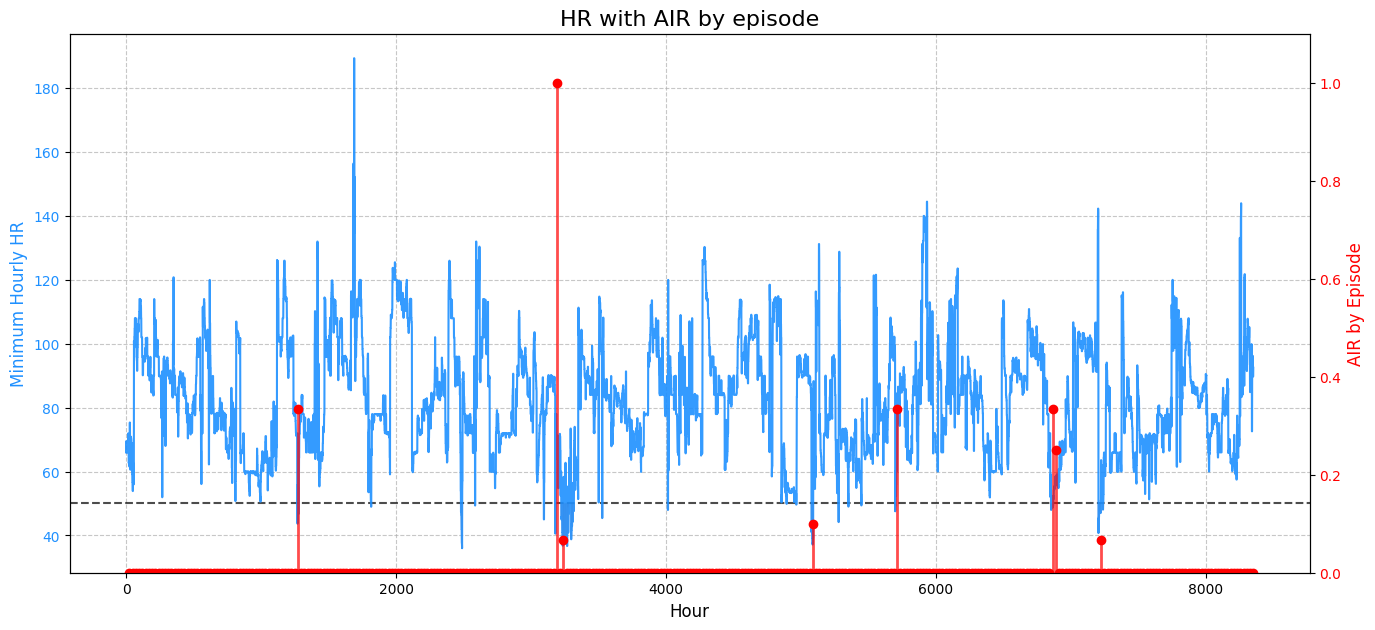

In [8]:
actions_np = np.array(actions_all)
states_np = np.array(states_all)
num_episodes = len(actions_np) // 144
new_size = num_episodes * 144
trimmed_actions = actions_np[:new_size]
trimmed_states = states_np[:new_size]

long_episode_actions = trimmed_actions.reshape(-1, 144)
num_features = states_np.shape[-1]
long_episode_states = trimmed_states.reshape(-1, 144, num_features)

all_episode_rates = []
for i in range(len(long_episode_actions)):
    episode_actions = long_episode_actions[i]
    episode_hr = long_episode_states[i, :, 9]
    rate = compute_hr_physician_air(episode_hr, episode_actions)
    all_episode_rates.append(rate)

episode_boundaries = np.arange(1, len(long_episode_actions) + 1) * 144
full_flattened_hr = long_episode_states[:, :, 9].flatten()

HOURLY_WINDOW = 6
num_windows = len(full_flattened_hr) // HOURLY_WINDOW
trimmed_hr_for_hourly_min = full_flattened_hr[:num_windows * HOURLY_WINDOW]

hourly_min_hr = trimmed_hr_for_hourly_min.reshape(-1, HOURLY_WINDOW).min(axis=1)
hourly_timesteps = np.arange(num_windows)
fig, ax1 = plt.subplots(figsize=(16, 7))
plt.title('HR with AIR by episode', fontsize=16)

color = 'dodgerblue'
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_ylabel('Minimum Hourly HR', color=color, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.plot(hourly_timesteps, hourly_min_hr, color=color, label='Min HR Per Hour', alpha=0.9, zorder=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=50, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.fill_between(hourly_timesteps, 50, hourly_min_hr, where=hourly_min_hr < 50, 
                 color='orangered', alpha=0.3, interpolate=True, label='Min HR < 50') 


ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('AIR by Episode', color=color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.1)


valid_rates = []
valid_boundaries_scaled = []
for i, rate in enumerate(all_episode_rates):
    valid_rates.append(rate)
    valid_boundaries_scaled.append(episode_boundaries[i] / HOURLY_WINDOW)


markerline, stemlines, baseline = ax2.stem(
    valid_boundaries_scaled,
    valid_rates,
    linefmt='red',
    markerfmt='ro',
    basefmt=' ',
    label='AIR'
)
plt.setp(stemlines, 'linewidth', 2, 'alpha', 0.7)
plt.show()


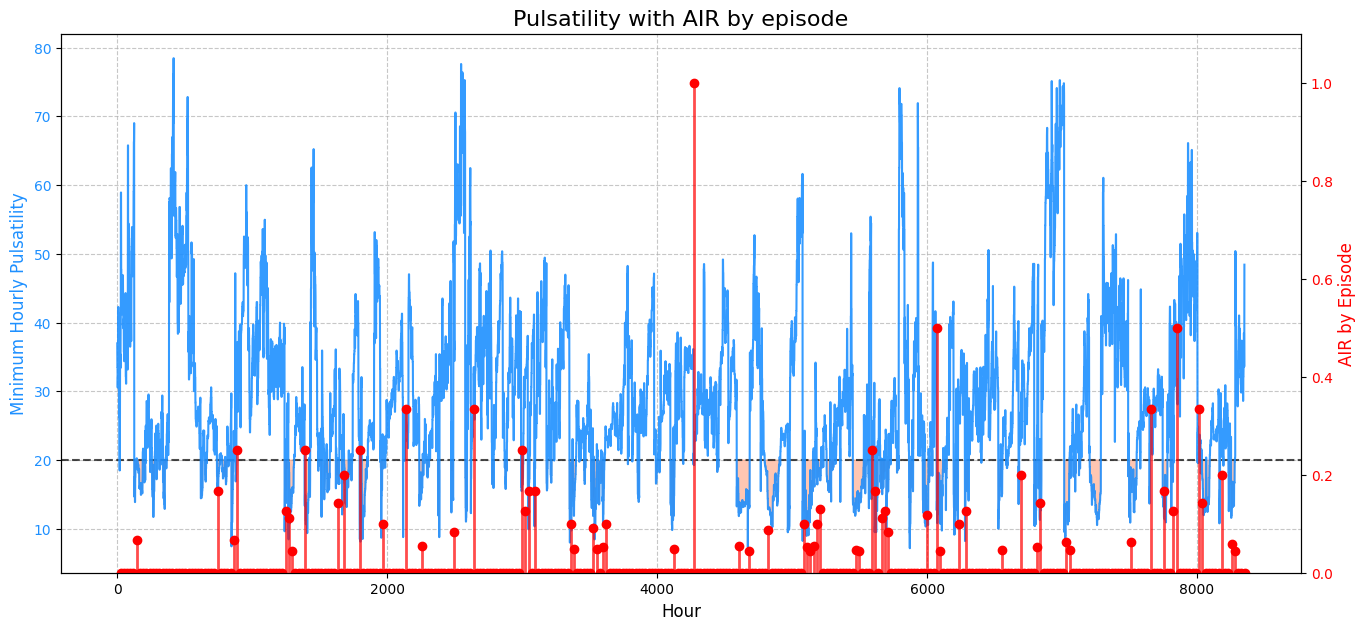

In [9]:
actions_np = np.array(actions_all)
states_np = np.array(states_all)
num_episodes = len(actions_np) // 144
new_size = num_episodes * 144
trimmed_actions = actions_np[:new_size]
trimmed_states = states_np[:new_size]

long_episode_actions = trimmed_actions.reshape(-1, 144)
num_features = states_np.shape[-1]
long_episode_states = trimmed_states.reshape(-1, 144, num_features)

all_episode_rates = []
for i in range(len(long_episode_actions)):
    episode_actions = long_episode_actions[i]
    episode_pulsatility = long_episode_states[i, :, 7]
    rate = compute_pulsatility_physician_air(episode_pulsatility, episode_actions)
    all_episode_rates.append(rate)

episode_boundaries = np.arange(1, len(long_episode_actions) + 1) * 144
full_flattened_pulsatility = long_episode_states[:, :, 7].flatten()

HOURLY_WINDOW = 6
num_windows = len(full_flattened_pulsatility) // HOURLY_WINDOW
trimmed_pulsatility_for_hourly_min = full_flattened_pulsatility[:num_windows * HOURLY_WINDOW]

hourly_min_pulsatility = trimmed_pulsatility_for_hourly_min.reshape(-1, HOURLY_WINDOW).min(axis=1)
hourly_timesteps = np.arange(num_windows)
fig, ax1 = plt.subplots(figsize=(16, 7))
plt.title('Pulsatility with AIR by episode', fontsize=16)

color = 'dodgerblue'
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_ylabel('Minimum Hourly Pulsatility', color=color, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.plot(hourly_timesteps, hourly_min_pulsatility, color=color, label='Min Pulsatility Per Hour', alpha=0.9, zorder=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=20, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.fill_between(hourly_timesteps, 20, hourly_min_pulsatility, where=hourly_min_pulsatility < 20, 
                 color='orangered', alpha=0.3, interpolate=True, label='Min Pulsatility < 20') 


ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('AIR by Episode', color=color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.1)


valid_rates = []
valid_boundaries_scaled = []
for i, rate in enumerate(all_episode_rates):
    valid_rates.append(rate)
    valid_boundaries_scaled.append(episode_boundaries[i] / HOURLY_WINDOW)


markerline, stemlines, baseline = ax2.stem(
    valid_boundaries_scaled,
    valid_rates,
    linefmt='red',
    markerfmt='ro',
    basefmt=' ',
    label='AIR'
)
plt.setp(stemlines, 'linewidth', 2, 'alpha', 0.7)
plt.show()


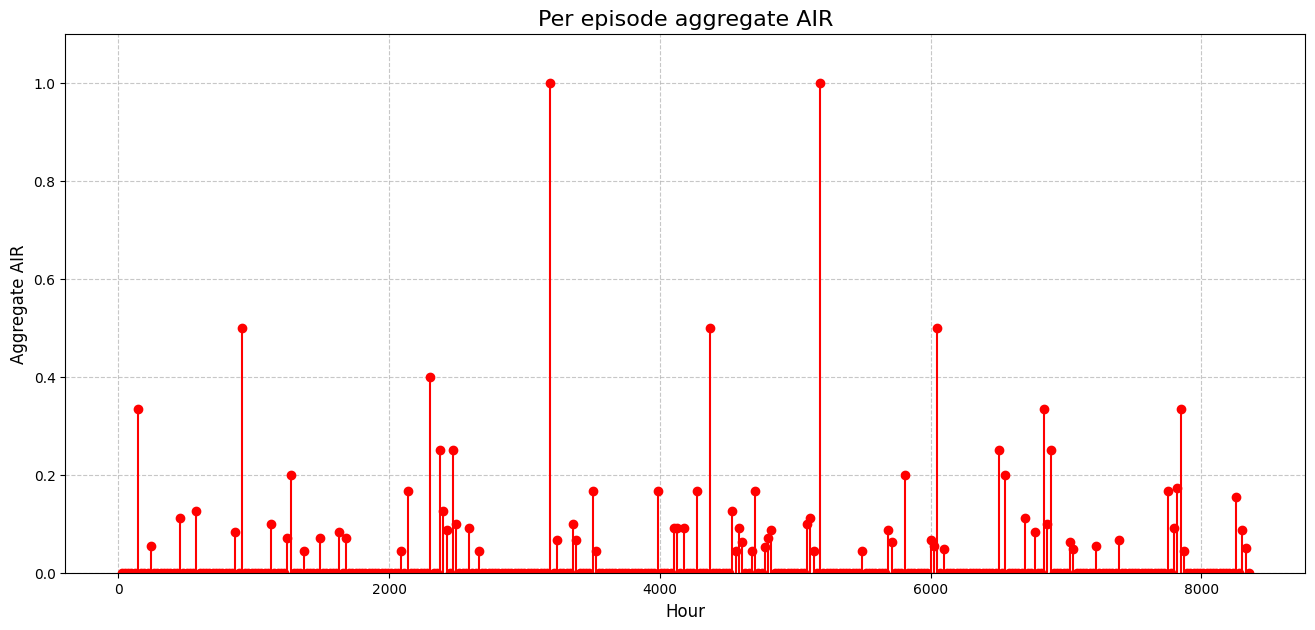

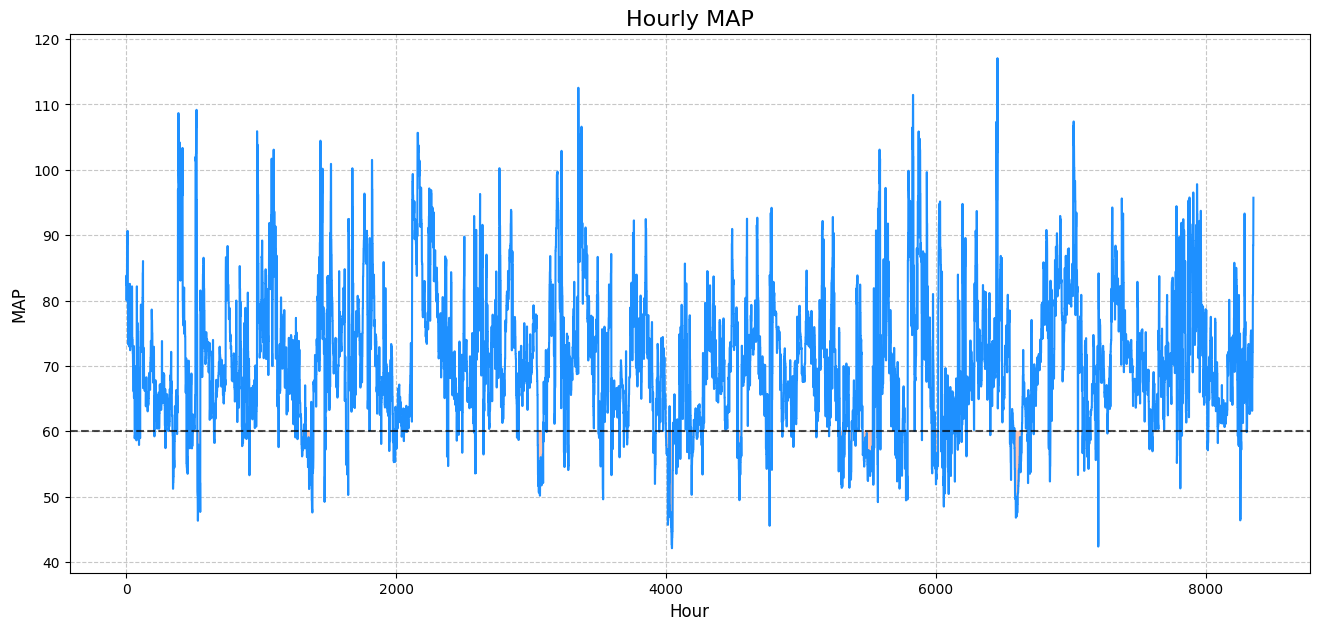

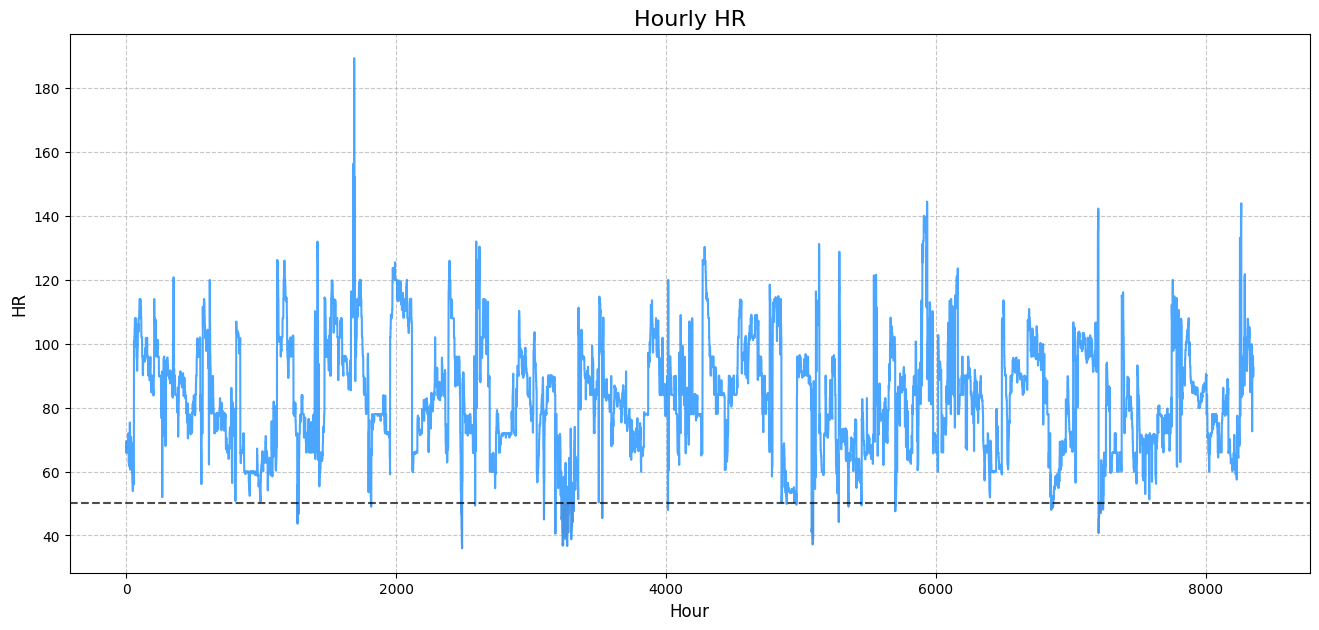

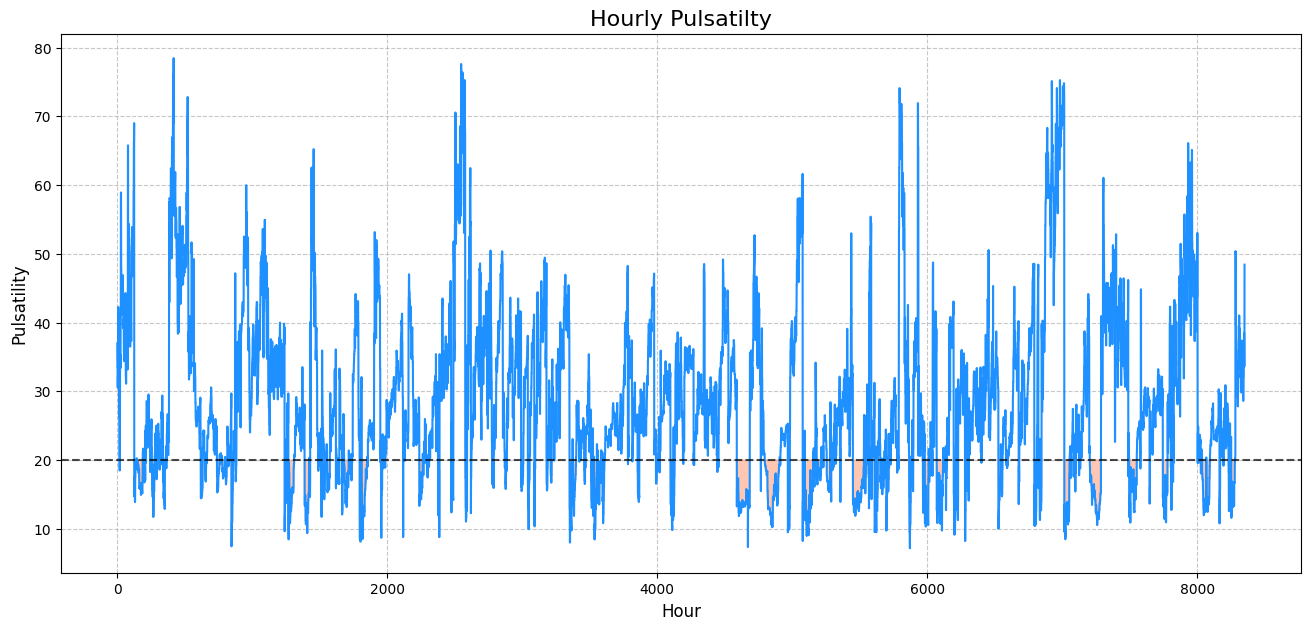

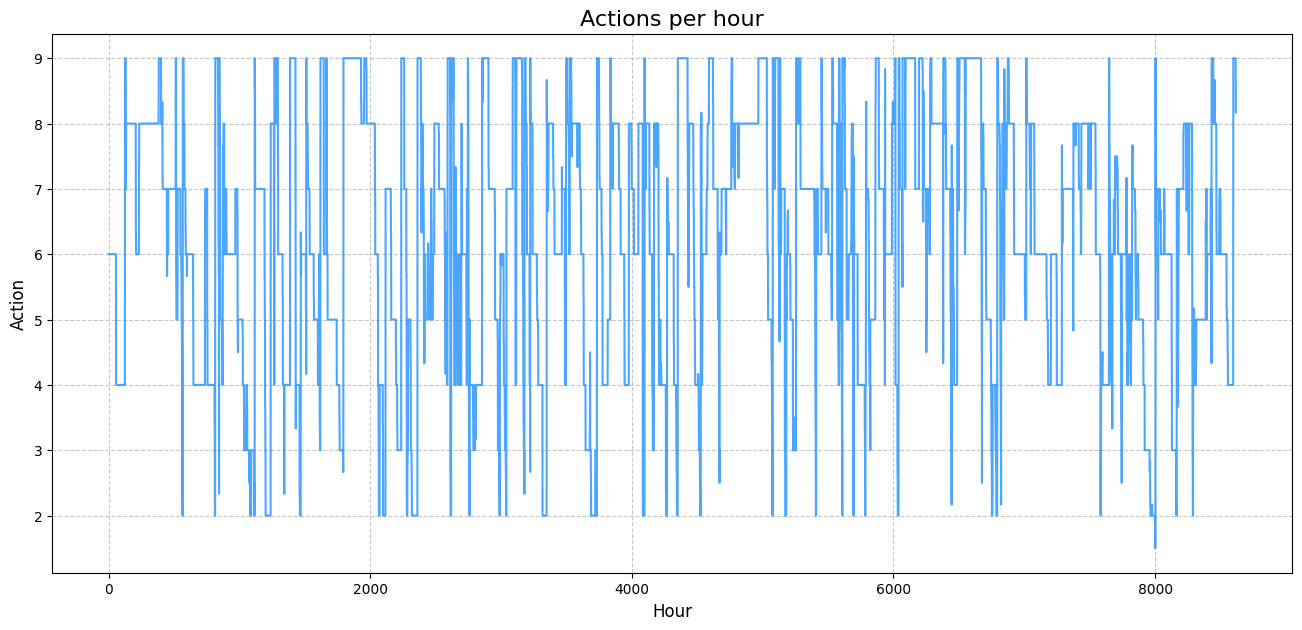

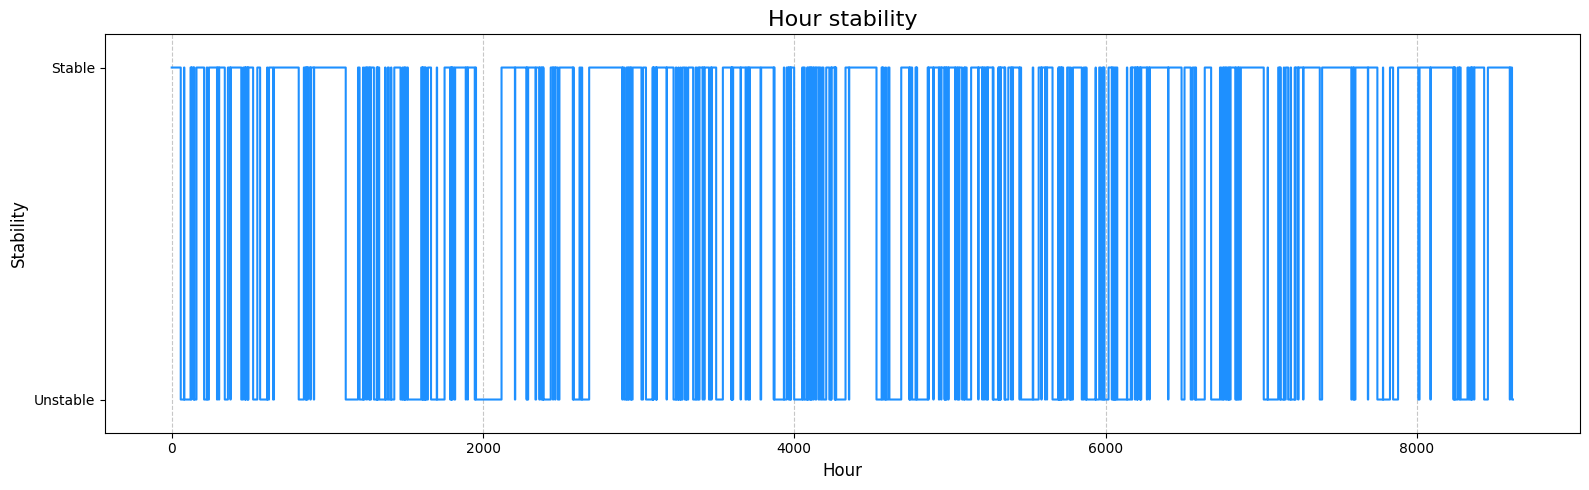

In [23]:
aggregate_air_scores = []
for i in range(len(long_episode_actions)):
    episode_states = long_episode_states[i]
    episode_actions = long_episode_actions[i]
    rate = aggregate_air_physician(episode_states, episode_actions)
    aggregate_air_scores.append(rate)

HOURLY_WINDOW = 6
fig, ax = plt.subplots(figsize=(16, 7))
episode_boundaries_scaled = np.arange(1, len(long_episode_actions) + 1) * (144 / HOURLY_WINDOW)
ax.stem(episode_boundaries_scaled, aggregate_air_scores, linefmt='red', markerfmt='ro', basefmt=' ')
ax.set_title('Per episode aggregate AIR', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Aggregate AIR', fontsize=12)
ax.set_ylim(0, 1.1)
ax.grid(True, linestyle='--', alpha=0.7)

MAP_IDX = 0
HR_IDX = 9
PULSATILITY_IDX = 7

full_flattened_map = long_episode_states[:, :, MAP_IDX].flatten()
num_windows = len(full_flattened_map) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_min_map = full_flattened_map[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW).min(axis=1)
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_min_map, color='dodgerblue')
ax.axhline(y=60, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.fill_between(hourly_timesteps, 60, hourly_min_map, where=hourly_min_map < 60,
                color='orangered', alpha=0.3, interpolate=True, label='Min MAP < 60')
ax.set_title('Hourly MAP', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('MAP', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)


full_flattened_hr = long_episode_states[:, :, HR_IDX].flatten()
num_windows = len(full_flattened_hr) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_reshaped_hr = full_flattened_hr[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW)
hourly_min_hr = hourly_reshaped_hr.min(axis=1)
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_min_hr, color='dodgerblue', alpha=0.8)
ax.axhline(y=50, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.fill_between(hourly_timesteps, 50, hourly_min_hr, where=hourly_min_hr < 50,
                color='orangered', alpha=0.3, interpolate=True, label='HR < 50')
ax.set_title('Hourly HR', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('HR', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)


full_flattened_pi = long_episode_states[:, :, PULSATILITY_IDX].flatten()
num_windows = len(full_flattened_pi) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_min_pi = full_flattened_pi[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW).min(axis=1)
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_min_pi, color='dodgerblue')
ax.axhline(y=20, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.fill_between(hourly_timesteps, 20, hourly_min_pi, where=hourly_min_pi < 20,
                color='orangered', alpha=0.3, interpolate=True, label='Min Pulsatility < 20')
ax.set_title('Hourly Pulsatilty', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Pulsatility', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

flattened_actions = actions_all.flatten()
num_windows = len(flattened_actions) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_reshaped_actions = flattened_actions[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW)
hourly_mean_actions = hourly_reshaped_actions.mean(axis=1) 
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_mean_actions, color='dodgerblue', alpha=0.8)
ax.set_title('Actions per hour', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Action', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)


flattened_states = states_all.reshape(-1, states_all.shape[-1])
hourly_stability = []
for i in range(0, len(flattened_states) - 5, 6):
    hour_chunk = flattened_states[i : i+6]
    stability_flag = int(is_stable(hour_chunk))
    hourly_stability.append(stability_flag)
hourly_timesteps = np.arange(len(hourly_stability))
fig, ax = plt.subplots(figsize=(16, 5))
ax.step(hourly_timesteps, hourly_stability, where='post', color='dodgerblue', linewidth=1.5)
ax.set_title('Hour stability', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Stability', fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Unstable', 'Stable'])
ax.set_ylim(-0.1, 1.1)
ax.grid(True, linestyle='--', alpha=0.7, axis='x')

plt.tight_layout()
plt.show()


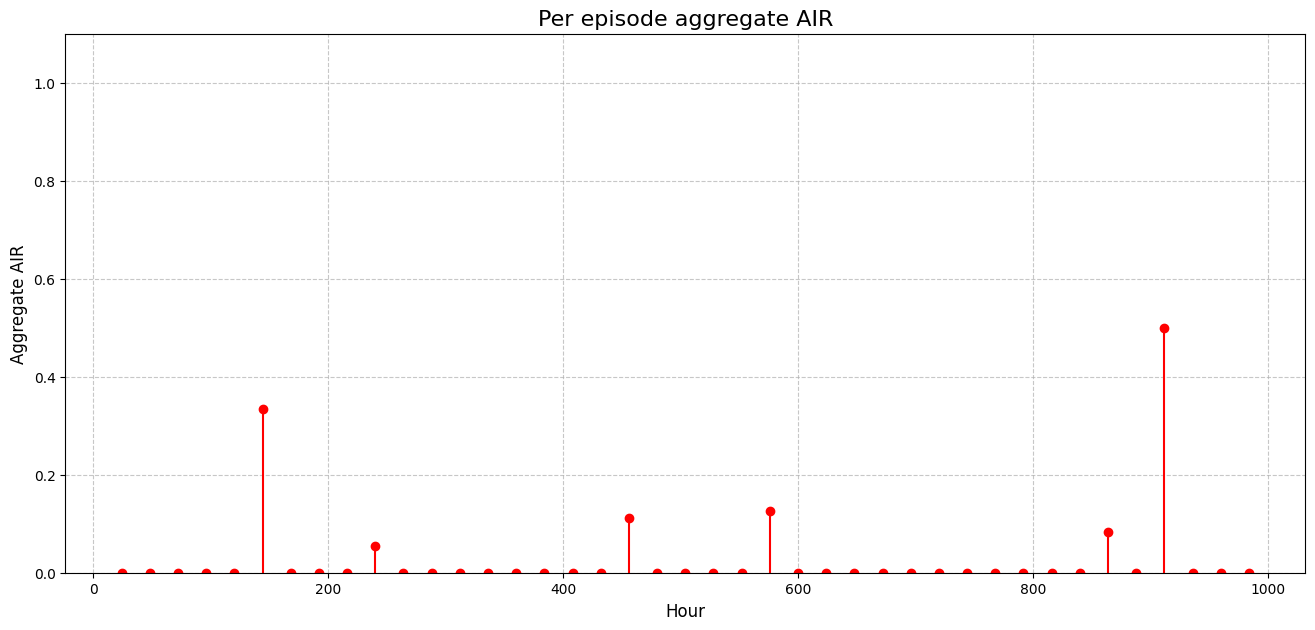

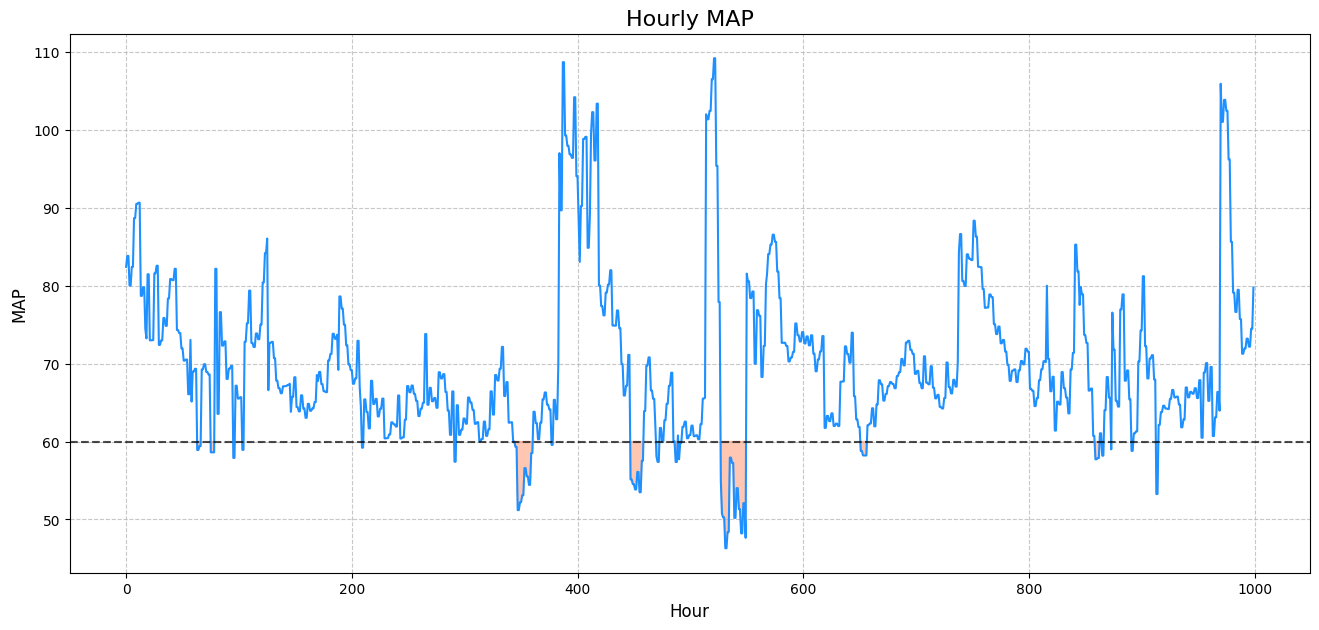

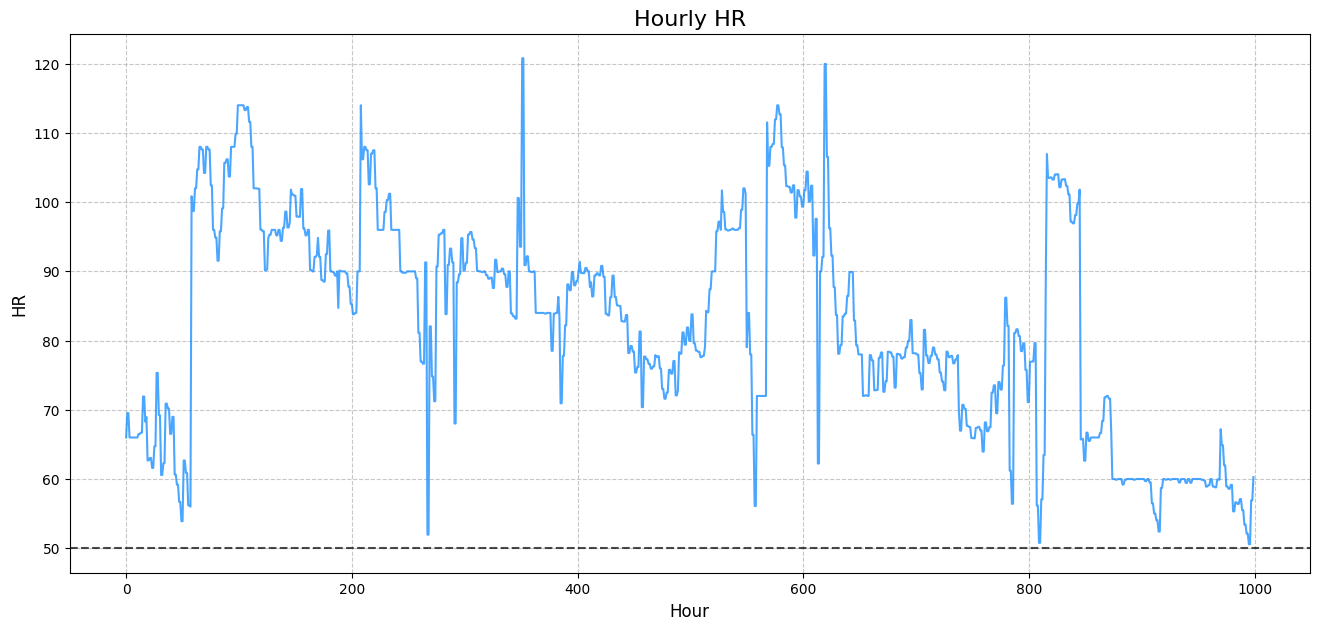

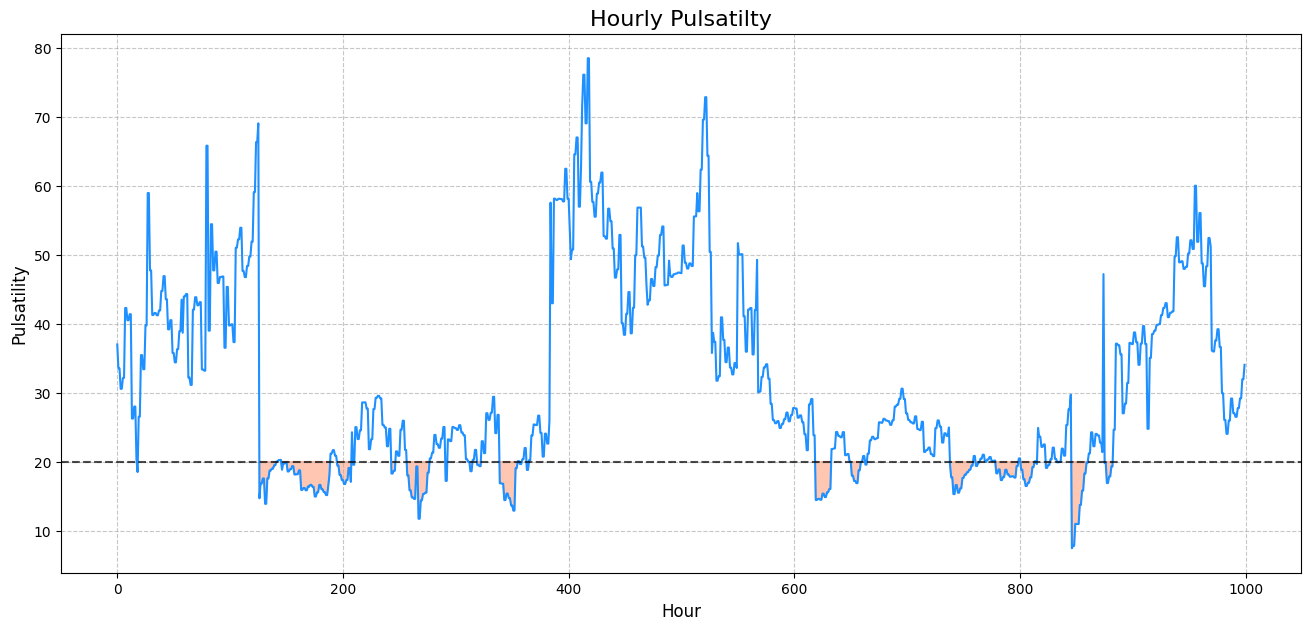

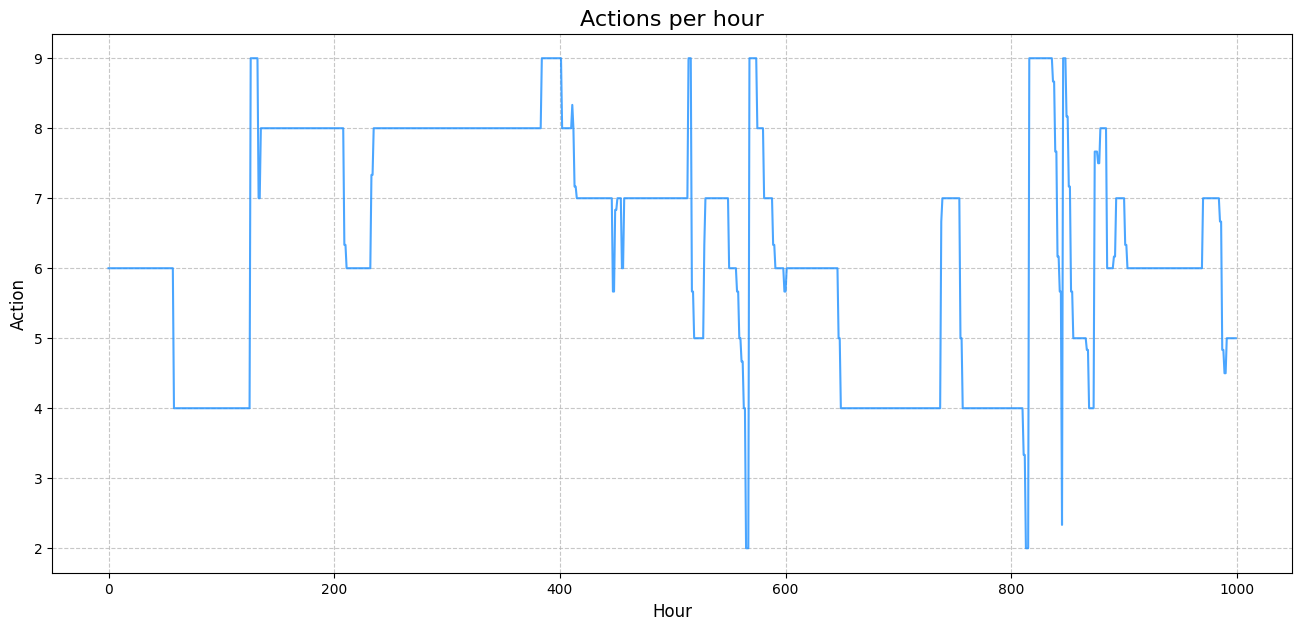

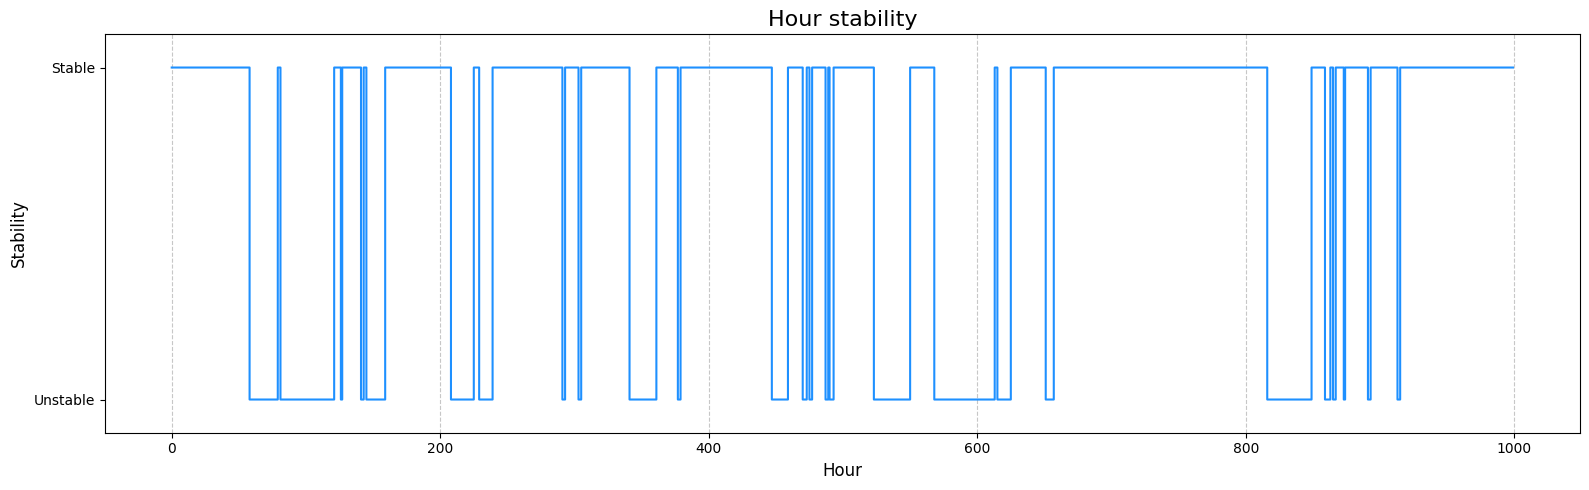

In [22]:
MAX_HOURS = 1000
aggregate_air_scores = []
for i in range(len(long_episode_actions)):
    episode_states = long_episode_states[i]
    episode_actions = long_episode_actions[i]
    rate = aggregate_air_physician(episode_states, episode_actions)
    aggregate_air_scores.append(rate)

HOURLY_WINDOW = 6
fig, ax = plt.subplots(figsize=(16, 7))

EPISODE_DURATION_HOURS = 144 / HOURLY_WINDOW
num_episodes_to_plot = int(MAX_HOURS // EPISODE_DURATION_HOURS)
aggregate_air_scores = aggregate_air_scores[:num_episodes_to_plot]
episode_boundaries_scaled = np.arange(1, len(aggregate_air_scores) + 1) * EPISODE_DURATION_HOURS

ax.stem(episode_boundaries_scaled, aggregate_air_scores, linefmt='red', markerfmt='ro', basefmt=' ')
ax.set_title('Per episode aggregate AIR', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Aggregate AIR', fontsize=12)
ax.set_ylim(0, 1.1)
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()

MAP_IDX = 0
HR_IDX = 9
PULSATILITY_IDX = 7

full_flattened_map = long_episode_states[:, :, MAP_IDX].flatten()
num_windows = len(full_flattened_map) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_min_map = full_flattened_map[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW).min(axis=1)

hourly_timesteps = hourly_timesteps[:MAX_HOURS]
hourly_min_map = hourly_min_map[:MAX_HOURS]

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_min_map, color='dodgerblue')
ax.axhline(y=60, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.fill_between(hourly_timesteps, 60, hourly_min_map, where=hourly_min_map < 60,
                color='orangered', alpha=0.3, interpolate=True, label='Min MAP < 60')
ax.set_title('Hourly MAP', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('MAP', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()


full_flattened_hr = long_episode_states[:, :, HR_IDX].flatten()
num_windows = len(full_flattened_hr) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_reshaped_hr = full_flattened_hr[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW)
hourly_min_hr = hourly_reshaped_hr.min(axis=1)

hourly_timesteps = hourly_timesteps[:MAX_HOURS]
hourly_min_hr = hourly_min_hr[:MAX_HOURS]

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_min_hr, color='dodgerblue', alpha=0.8)
ax.axhline(y=50, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.fill_between(hourly_timesteps, 50, hourly_min_hr, where=hourly_min_hr < 50,
                color='orangered', alpha=0.3, interpolate=True, label='HR < 50')
ax.set_title('Hourly HR', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('HR', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()


full_flattened_pi = long_episode_states[:, :, PULSATILITY_IDX].flatten()
num_windows = len(full_flattened_pi) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_min_pi = full_flattened_pi[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW).min(axis=1)

hourly_timesteps = hourly_timesteps[:MAX_HOURS]
hourly_min_pi = hourly_min_pi[:MAX_HOURS]

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_min_pi, color='dodgerblue')
ax.axhline(y=20, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.fill_between(hourly_timesteps, 20, hourly_min_pi, where=hourly_min_pi < 20,
                color='orangered', alpha=0.3, interpolate=True, label='Min Pulsatility < 20')
ax.set_title('Hourly Pulsatilty', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Pulsatility', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()

flattened_actions = actions_all.flatten()
num_windows = len(flattened_actions) // HOURLY_WINDOW
hourly_timesteps = np.arange(num_windows)
hourly_reshaped_actions = flattened_actions[:num_windows * HOURLY_WINDOW].reshape(-1, HOURLY_WINDOW)
hourly_mean_actions = hourly_reshaped_actions.mean(axis=1)

hourly_timesteps = hourly_timesteps[:MAX_HOURS]
hourly_mean_actions = hourly_mean_actions[:MAX_HOURS]

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(hourly_timesteps, hourly_mean_actions, color='dodgerblue', alpha=0.8)
ax.set_title('Actions per hour', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Action', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()


flattened_states = states_all.reshape(-1, states_all.shape[-1])
hourly_stability = []
for i in range(0, len(flattened_states) - 5, 6):
    hour_chunk = flattened_states[i : i+6]
    stability_flag = int(is_stable(hour_chunk))
    hourly_stability.append(stability_flag)
    
hourly_timesteps = np.arange(len(hourly_stability))
hourly_timesteps = hourly_timesteps[:MAX_HOURS]
hourly_stability = hourly_stability[:MAX_HOURS]

fig, ax = plt.subplots(figsize=(16, 5))
ax.step(hourly_timesteps, hourly_stability, where='post', color='dodgerblue', linewidth=1.5)
ax.set_title('Hour stability', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Stability', fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Unstable', 'Stable'])
ax.set_ylim(-0.1, 1.1)
ax.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.tight_layout()
plt.show()

In [29]:
MAX_HOURS = 1000
EPISODE_HOUR = 24
num_episodes_to_score = int(np.ceil(MAX_HOURS / EPISODE_HOUR))
num_episodes_to_score = min(num_episodes_to_score, len(long_episode_actions))
weaning_scores = []
for i in range(num_episodes_to_score):
    score = weaning_score_physician(long_episode_states[i], long_episode_actions[i])
    weaning_scores.append(score)
average_weaning_score = np.mean(weaning_scores)
print(f"Average weaning score for first {num_episodes_to_score} episodes: {average_weaning_score:.4f}")

Average weaning score for first 42 episodes: 0.0134
